In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
    if not os.path.isdir(housing_path):
         os.makedirs(housing_path)
         tgz_path = os.path.join(housing_path, "housing.tgz")
         urllib.request.urlretrieve(housing_url, tgz_path)
         housing_tgz = tarfile.open(tgz_path)
         housing_tgz.extractall(path=housing_path)
         housing_tgz.close()
        
def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    #pandas can read a csv directly 
    return pd.read_csv(csv_path)


In [2]:
fetch_housing_data()


In [3]:
housing = load_housing_data()

In [4]:
#doing the standard exploratory data probing here 

#The info command from pandas gives all the columns and the associated data type
housing.info()

#Head just shows the head of the data
housing.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
#Another pandas method where they are counting the number of occurances
#We are doign this because we hope to make the values numeric
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#This is another broad method that gives some intro statistics for all of the rows in the data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


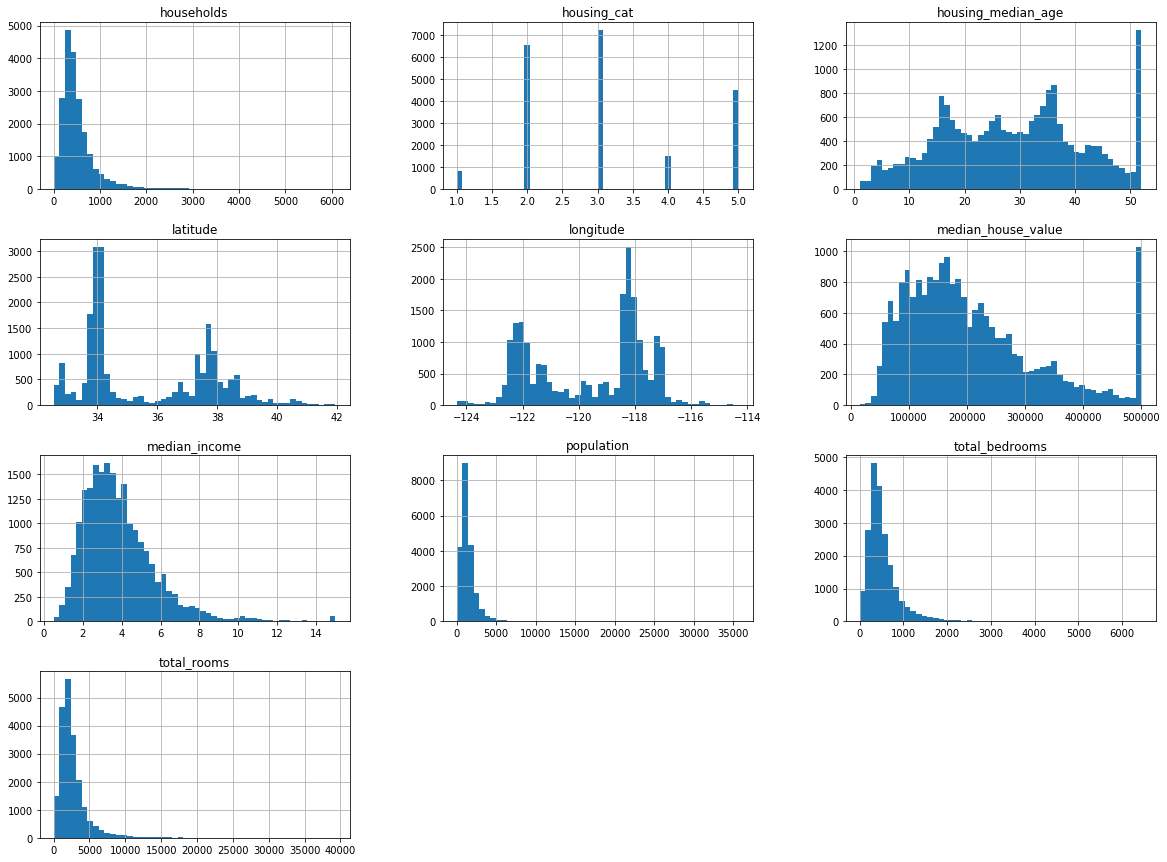

In [9]:
%matplotlib inline
#The above only works in jupyter notebooks

#Let's make some good histograms with this stuff
housing.hist(bins=50, figsize=(20,15))
plt.show()

#We see some interesting spikes in median age and housign value

#Those spikes are probably attributed to some cap that was done in the preprocesing stage of the data
#The cap on the median value actually poses a problem because it is literally your target attribute
#We can either relabel the data (unlikey) or we can cap it off at the range we actually need.

#We also see that the median income is not expresed inm US Dollars?? We need to do soemthing about that 

#All of the attributes have a very different scale, this will also pose a problem down the road

#Many of the histograms are also very tail heavy

In [13]:
#After we have done the initial exploring, we need to split off our testing data and never look at it again.
#This to prevent your brain from pciking up small biases in the data and making a bias.
#Notice how we are splitting the data randomly
#We also want to add a seed to keep the random splitting consistant 
#We can afford to do this randomly because we have enough datapoints, sometimes we have to be more careful

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
#Making the call to our split function
train_set, test_set = split_train_test(housing, 0.2)

In [7]:
#Say we heard that median income is a very important factor in determining housing value
#Let's split our data such that there is an equal representation of both
#The real problem here is that the median income is a continuos value, we need to make it discrete to split
#Let's create a new atrtirbute that is discrete such that we can split it all up

housing['housing_cat'] = np.ceil(housing['median_income']/1.5)
housing['housing_cat'].where(housing['median_income'] < 5, 5.0, inplace=True)

In [8]:
#Now that we have our new attribute, we can use stratified sampliing to create a even split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["housing_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [10]:
print(len(strat_train_set), len(strat_test_set))

#This gives us the percentage breakdown of the housing catagory value with all the data
housing["housing_cat"].value_counts()/len(housing)

16512 4128


3.0    0.350581
2.0    0.318847
5.0    0.218459
4.0    0.072287
1.0    0.039826
Name: housing_cat, dtype: float64

In [11]:
#Now that we have correctly split up our data, we want to remove this feature to return to og state
for set in (strat_train_set, strat_test_set): 
    set.drop(["housing_cat"], axis=1, inplace=True)

In [12]:
#For the remainder of this project, we are going to use the train set as housing
housing = strat_train_set.copy()

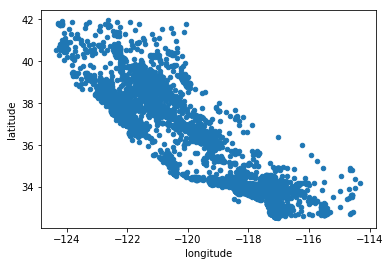

In [13]:
#Now we begin the visualization stage
#Since we have geographical data, it's good that we utilize that 
housing.plot(kind="scatter", x="longitude", y="latitude")

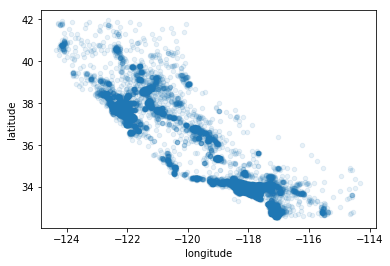

In [14]:
#Let's make it so that we can actually see it by toggling the alpha option, which allows for better density visualization

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=.1)

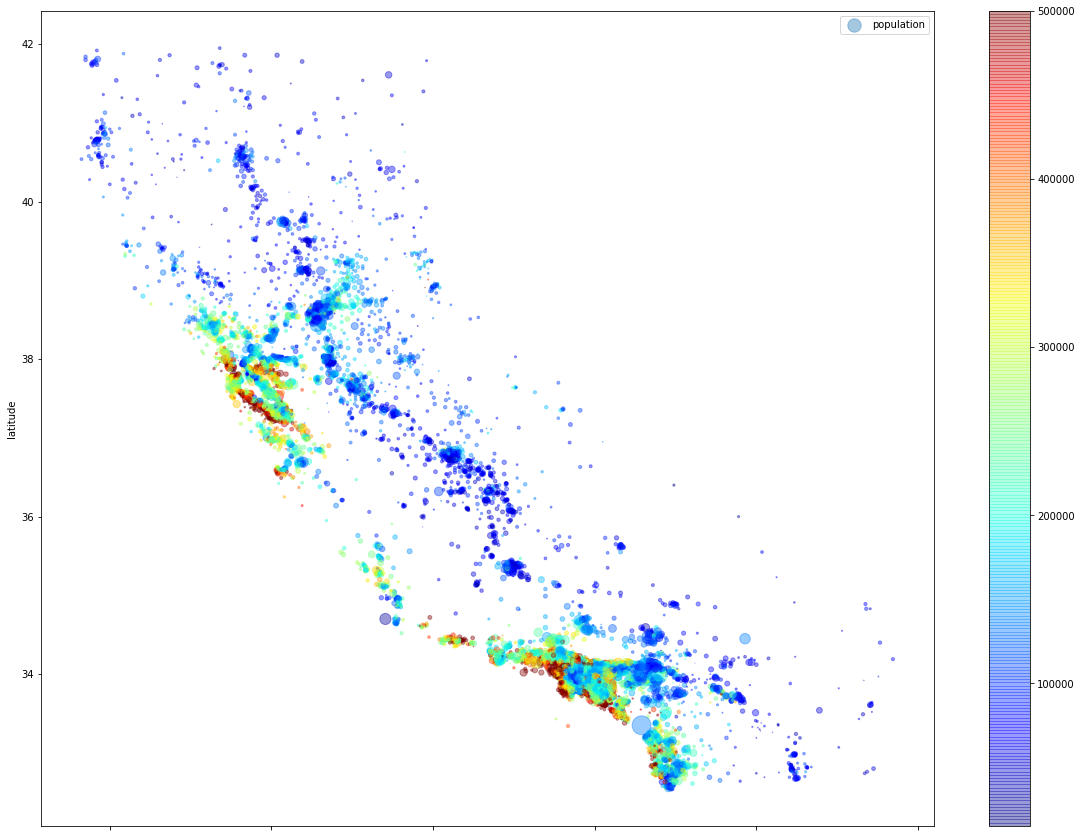

In [15]:
#Now let's add in some other attributes in the data to get a better visualization
#We will set the size of the dots to the size of the population scaled down by 100
#cmap stands for color map and is part of matplotlib, we use the jet theme
#Also going to bump up the alpha

#We can clearly see that location is closely related to housing value
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=.4, 
            s=housing['population']/100, label="population", 
            c=housing['median_house_value'], cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,15))
plt.legend()

In [16]:
#Let's start lookign for correlations
#We can start with the basic r coeffecient between your attributes

corr_matrix = housing.corr()

In [17]:
#Now let's sort by the target value to try and find some correlations
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687752
total_rooms           0.136422
housing_median_age    0.106985
households            0.066340
total_bedrooms        0.050081
population           -0.024622
longitude            -0.047586
latitude             -0.142814
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a259cce48>,
      dtype=object)

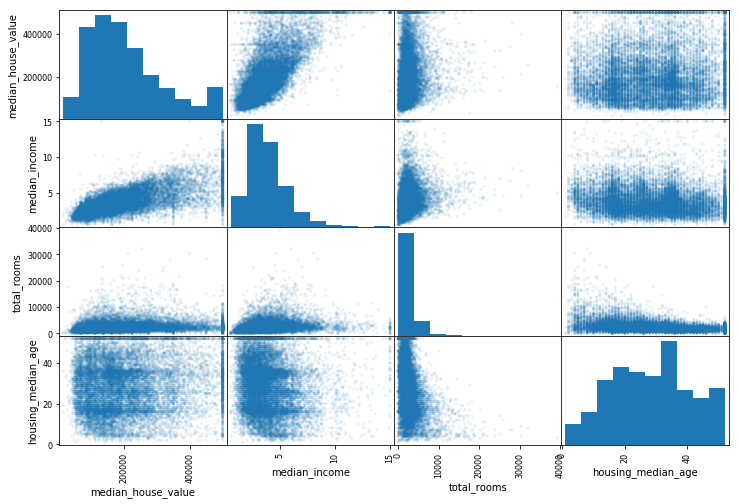

In [18]:
#Since the correlation coeffecient misses a lot, let's do a pandas scatter matrix
#The scatter matrix plots everything against everything else, so let's just choose a few haha 

from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

#Pretty cool splitting here with housing, just pass in a list of the features that you want to work with
#Lower the alpha to get a better look
scatter_matrix(housing[attributes], figsize=(12,8), alpha=.1)

#Notice the price cap in income
#Also, notice the horizontal line around 450k in income, interesting

#As we continue, we will often revisit the exploration step to find new quirks and add in some features

In [19]:
#Now let's prepare the data for machine learing
#We want to automate things so that we can do them again

#We start by dropping our target value (obviously)
#We also want to split off our labels for seperate input 
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [21]:
#Ok now we need to fill in the broken values in the data 
#We have three options here
#1. Get rid of the entries with broken values 
#2. Get rid of the entire attribute 
#3. Set the broken values to some value, usually the median or something 
#All of the above can be acomplished with the pandas dataframe method

#Here we are going to go with the third option and replace it with the median values
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)

17172     164.0
5293      656.0
14663     534.0
13986     619.0
16896     734.0
          ...  
19786     300.0
9969      393.0
14621    1051.0
9183     3945.0
11682    1615.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [26]:
#We are actually going to use an interested tool called an imputer from scikitlearn to do the above to all data
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

#First, split off the non-numerical attribute ocean prox
housing_num=housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

#Outputs a plain numpy array that we need to put back into a pandas dataframe
X=imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)


/Users/porterhunley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
#Now that our numerical data is taken care of, we can focus on the textual data
#The classic way to deal with textual data is to turn it into numerical values
#We cannot simply label them numebrs as the ML algorithms will assume that numbers closer are more related
#We will use an encoder to help us label the data in an acceptable manner

from sklearn.preprocessing import LabelBinarizer

#The sparse matrix is a matrix that doesn't waste memory by storing dumb 0's
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing['ocean_proximity'])


In [1]:
#The SciKitLearn transformations are useful and all, but we need to make our own transformers for production
#This one is going to add a couple of new features to the dataset 

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
        population_per_household = X[:, population_ix] / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_houshold, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [3]:
#Now we want to create our own transformation pipelines 
#This is just a small example of a pipeline, just adds some stuff and scales the fatures
#NOTE: Feature scalling is extremely important in Mahcine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])



/Users/porterhunley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
#After exploring and preparing the data, we are ready to select and train a model
